In [1]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'<<{_str}>>:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [2]:
!pip -q install lightning torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import lightning as L
from lightning.pytorch.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
from torchvision.transforms import v2
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__,L.__version__

('2.6.0+cu124', '2.5.1.post0')

# Layer APIs   
 https://pytorch.org/docs/stable/nn.html  

## Activation functions

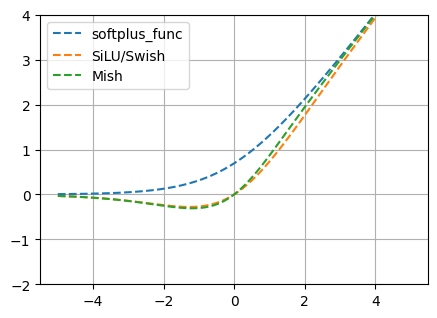

In [4]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-5, 5, 0.01)
x_tensor = torch.tensor(x, dtype=torch.float32)

# 기타
def softplus_func(x):
    return np.log(np.exp(x)+1)
plt.plot(x, softplus_func(x), linestyle='--', label="softplus_func")

def SiLU_func(x_tensor):
    return x_tensor*(F.sigmoid(x_tensor))
plt.plot(x, SiLU_func(x_tensor).numpy(), linestyle='--', label="SiLU/Swish")

def Mish_func(x_tensor):
    return x_tensor*torch.tanh(F.softplus(x_tensor))
plt.plot(x, Mish_func(x_tensor).numpy(), linestyle='--', label="Mish")

plt.ylim(-2, 4)
plt.legend()
plt.grid()
plt.show()

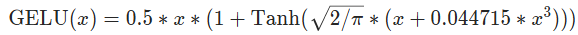

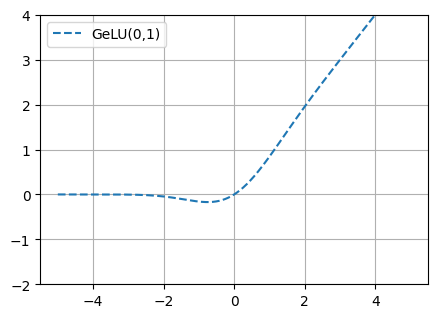

In [5]:
#GELU(x)=0.5*(1+Tanh(2/π*(x+0.044715*3)))
x = np.arange(-5, 5, 0.01)

# 기타
def GeLU_func(x):
    return 0.5*x*(1+np.tanh((np.sqrt(2/np.pi)*(x+0.044715*x**3))))

plt.plot(x, GeLU_func(x), linestyle='--', label="GeLU(0,1)")

plt.ylim(-2, 4)
plt.legend()
plt.grid()
plt.show()

## Gated Linear Unit

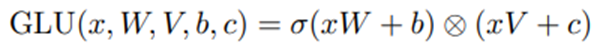

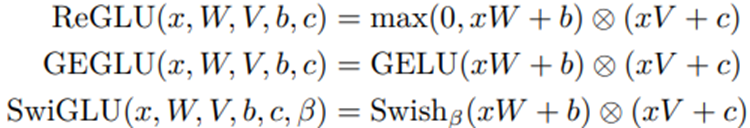

In [6]:
## Pytorch 구현 형태
class GLU(nn.Module):
    def __init__(self):
        super(GLU, self).__init__()
    def forward(self, x):
        assert x.size(-1) % 2 == 0
        split_dim = x.size(-1) // 2
        a, b = x[..., :split_dim], x[..., split_dim:]
        return a * torch.sigmoid(b)

## 선형변환이 포함된 GLU 구현
class GLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GLU, self).__init__()
        # 두 개의 선형 변환 정의
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        # GeGLU 공식 구현
        gate1 = self.linear1(x)
        gate2 = self.sigmoid(self.linear2(x))
        return gate1 * gate2

class ReGLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ReGLU, self).__init__()
        # 두 개의 선형 변환 정의
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        # GeGLU 공식 구현
        gate1 = self.linear1(x)
        gate2 = self.relu(self.linear2(x))
        return gate1 * gate2

class GeGLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GeGLU, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(input_dim, hidden_dim)
        self.gelu = nn.GELU()
    def forward(self, x):
        gate1 = self.linear1(x)
        gate2 = self.gelu(self.linear2(x))
        return gate1 * gate2

## Activation function에 따른 성능 비교

In [7]:
from torchvision.datasets import MNIST
from torchvision.transforms import v2
from torch.utils import data
from torch.utils.data import DataLoader

class MNISTDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str = '', batch_size: int = 1024):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size

  def setup(self, stage):
    # transforms for images
    transform = v2.Compose([
        v2.ToImage(),        # 다양한 image type -> torchvision.tv_tensors.Image type
        v2.ToDtype(torch.float32, scale=True) ] )
    self.mnist_test = MNIST(self.data_dir, train=False, transform=transform, download=True)
    mnist_full = MNIST(self.data_dir, train=True, transform=transform, download=True)
    self.mnist_train, self.mnist_val = data.random_split(mnist_full, [55000, 5000])

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=4)
  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=4)
  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=4)

data_module = MNISTDataModule(batch_size=256)

## Base model

In [8]:
class Wrap_10(L.LightningModule):
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [9]:
class Model(Wrap_10):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.layers(x)
        return x
model = Model()
summary(model, input_size=(8, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 128]                  100,480
│    └─ReLU: 2-3                         [8, 128]                  --
│    └─Linear: 2-4                       [8, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.81
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.41
Estimated Total Size (MB): 0.44

In [10]:
%%time
model = Model()

epochs = 50
name="ReLU_Model"
logger = L.pytorch.loggers.CSVLogger("logs", name=name)
trainer = L.Trainer(max_epochs=epochs, logger=logger, overfit_batches=0.25,enable_model_summary=False)
trainer.fit(model, data_module)
#Wall time: 1min 18s

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
100%|██████████| 9.91M/9.91M [00:11<00:00, 898kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.03MB/s]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 24.4 s, sys: 13.9 s, total: 38.3 s
Wall time: 1min 28s


In [11]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

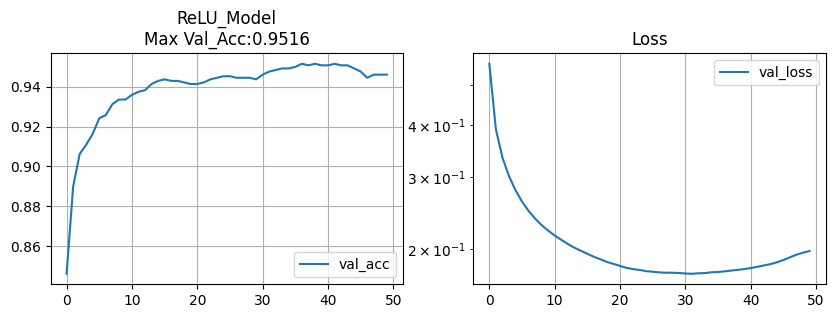

In [12]:
h1 = history.drop('step', axis=1).groupby('epoch').last()
max_ = h1['val_acc'].max()

plt.figure(figsize=(10,3))
title = name
plt.subplot(121)
plt.title(f"{title}\nMax Val_Acc:{max_:.4f}")
plt.plot(h1['val_acc'], label='val_acc')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['val_loss'], label='val_loss')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

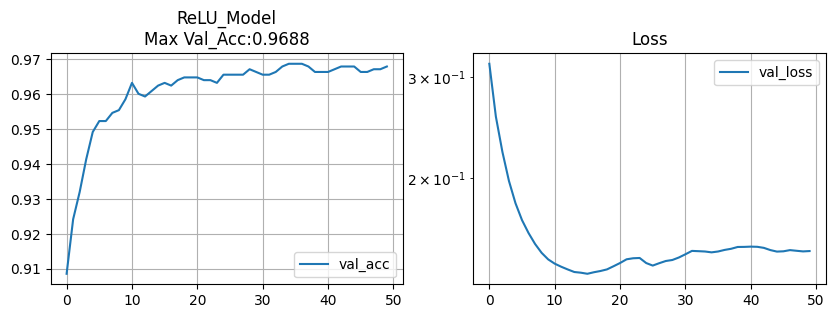

## Activation : PReLU, Mish,...

In [13]:
class Model2(Wrap_10):
    def __init__(self):
        super(Model2, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
#            nn.SELU(),
#            nn.PReLU(num_parameters=128),
            nn.Mish(),
#            nn.ReLU(),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.layers(x)
        return x

model = Model2()
summary(model, input_size=(8, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 128]                  100,480
│    └─Mish: 2-3                         [8, 128]                  --
│    └─Linear: 2-4                       [8, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.81
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.41
Estimated Total Size (MB): 0.44

In [14]:
%%time
model = Model2()
epochs = 50
#name="PReLU_Model"
name="Mish_Model"
#name="SELU_Model"
logger = L.pytorch.loggers.CSVLogger("logs", name=name)
trainer = L.Trainer(max_epochs=epochs, logger=logger, overfit_batches=0.25,enable_model_summary=False)
trainer.fit(model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 23.4 s, sys: 14.1 s, total: 37.5 s
Wall time: 1min 7s


Wall time: 1min 16s

In [15]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

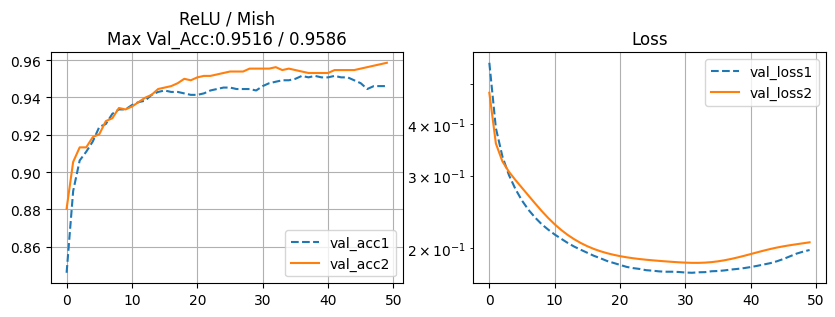

In [16]:
h2 = history.drop('step', axis=1).groupby('epoch').last()
max_1 = h1['val_acc'].max()
max_2 = h2['val_acc'].max()

plt.figure(figsize=(10,3))
title = "ReLU / Mish"
plt.subplot(121)
plt.title(f"{title}\nMax Val_Acc:{max_1:.4f} / {max_2:.4f}")
plt.plot(h1['val_acc'],'--', label='val_acc1')
plt.plot(h2['val_acc'], label='val_acc2')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['val_loss'],'--', label='val_loss1')
plt.plot(h2['val_loss'], label='val_loss2')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

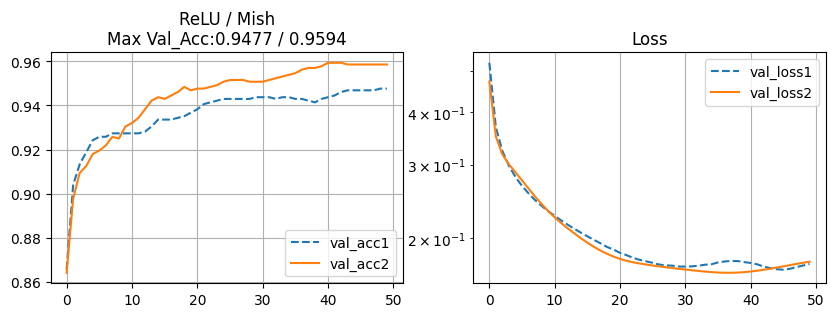

## Activation : GLU

In [17]:
class Model2(Wrap_10):
    def __init__(self):
        super(Model2, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.GLU(),
            nn.Linear(64, 10))

    def forward(self, x):
        x = self.layers(x)
        return x

model = Model2()
summary(model, input_size=(8, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 128]                  100,480
│    └─GLU: 2-3                          [8, 64]                   --
│    └─Linear: 2-4                       [8, 10]                   650
Total params: 101,130
Trainable params: 101,130
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.81
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.40
Estimated Total Size (MB): 0.44

In [18]:
%%time
model = Model2()
epochs = 50
name="GLU_Model"
logger = L.pytorch.loggers.CSVLogger("logs", name=name)
trainer = L.Trainer(max_epochs=epochs, logger=logger, overfit_batches=0.25,enable_model_summary=False)
trainer.fit(model, data_module)
#Wall time: 1min 4s

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 23.7 s, sys: 14.8 s, total: 38.6 s
Wall time: 1min 17s


Wall time: 1min 16s

In [19]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

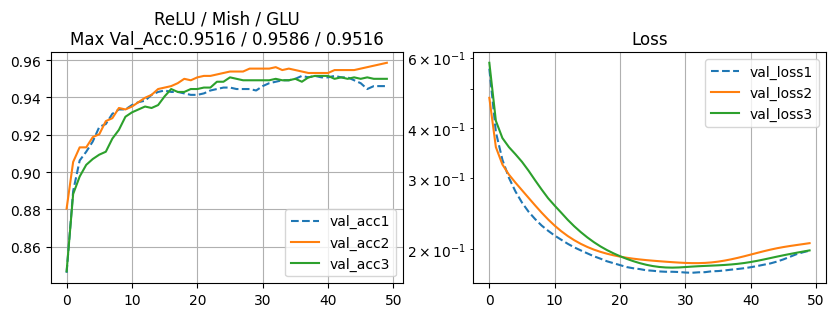

In [20]:
h3 = history.drop('step', axis=1).groupby('epoch').last()
# max_1 = h1['val_acc'].max()
# max_2 = h2['val_acc'].max()
max_3 = h3['val_acc'].max()

plt.figure(figsize=(10,3))
title = "ReLU / Mish / GLU"
plt.subplot(121)
plt.title(f"{title}\nMax Val_Acc:{max_1:.4f} / {max_2:.4f} / {max_3:.4f}")
plt.plot(h1['val_acc'],'--', label='val_acc1')
plt.plot(h2['val_acc'], label='val_acc2')
plt.plot(h3['val_acc'], label='val_acc3')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['val_loss'],'--', label='val_loss1')
plt.plot(h2['val_loss'], label='val_loss2')
plt.plot(h3['val_loss'], label='val_loss3')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

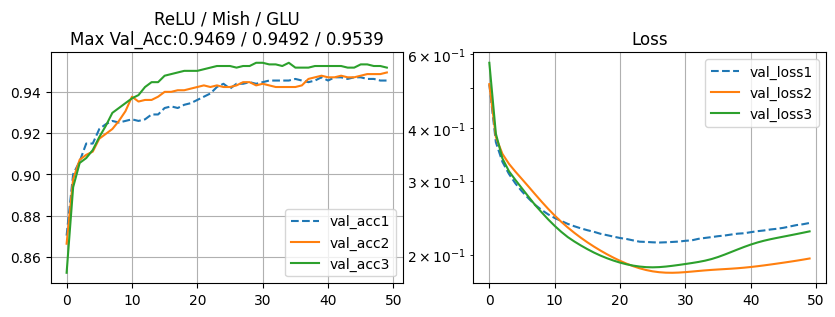

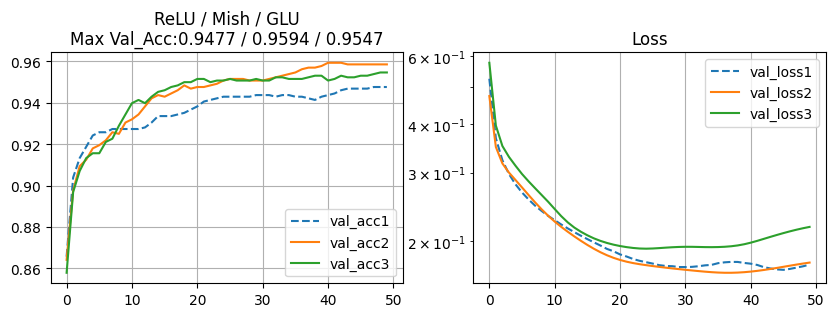

## Dropout

In [21]:
class Model4(Wrap_10):
    def __init__(self):
        super(Model4, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.layers(x)
        return x

model = Model4()
summary(model, input_size=(8, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model4                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 128]                  100,480
│    └─ReLU: 2-3                         [8, 128]                  --
│    └─Dropout: 2-4                      [8, 128]                  --
│    └─Linear: 2-5                       [8, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.81
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.41
Estimated Total Size (MB): 0.44

In [22]:
%%time
model = Model4()

name = 'Dropout'
logger = L.pytorch.loggers.CSVLogger("logs", name=name)
trainer = L.Trainer(max_epochs=epochs, logger=logger, overfit_batches=0.25,enable_model_summary=False)
trainer.fit(model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 23.9 s, sys: 14.8 s, total: 38.7 s
Wall time: 1min 9s


In [23]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

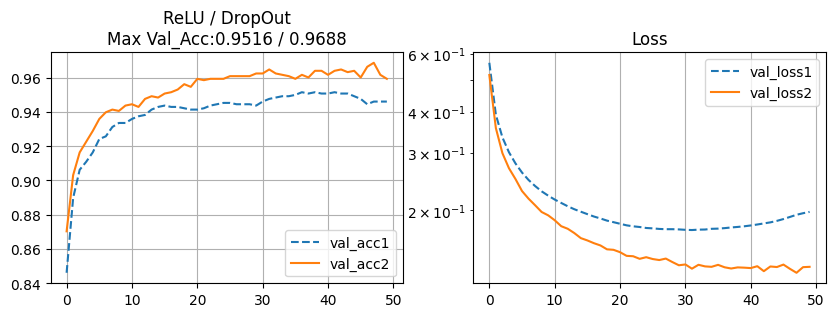

In [24]:
h2 = history.drop('step', axis=1).groupby('epoch').last()
max_1 = h1['val_acc'].max()
max_2 = h2['val_acc'].max()

plt.figure(figsize=(10,3))
title = "ReLU / DropOut"
plt.subplot(121)
plt.title(f"{title}\nMax Val_Acc:{max_1:.4f} / {max_2:.4f}")
plt.plot(h1['val_acc'],'--', label='val_acc1')
plt.plot(h2['val_acc'], label='val_acc2')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['val_loss'],'--', label='val_loss1')
plt.plot(h2['val_loss'], label='val_loss2')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

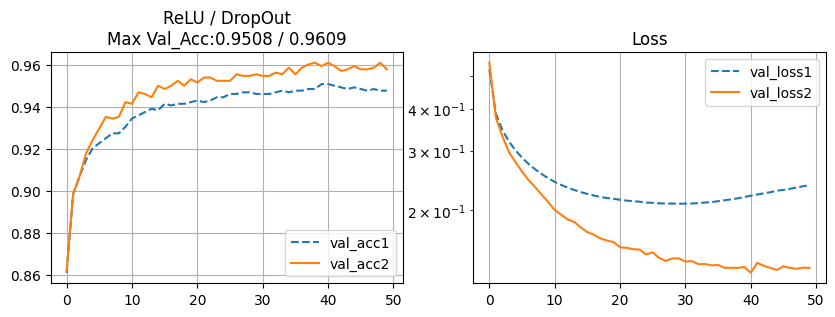

## BatchNormalization

In [25]:
class Model5(Wrap_10):
    def __init__(self):
        super(Model5, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.BatchNorm1d(10)
            )

    def forward(self, x):
        x = self.layers(x)
        return x

model = Model5()
summary(model, input_size=(8, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model5                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 128]                  100,480
│    └─BatchNorm1d: 2-3                  [8, 128]                  256
│    └─ReLU: 2-4                         [8, 128]                  --
│    └─Linear: 2-5                       [8, 10]                   1,290
│    └─BatchNorm1d: 2-6                  [8, 10]                   20
Total params: 102,046
Trainable params: 102,046
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.82
Input size (MB): 0.03
Forward/backward pass size (MB): 0.02
Params size (MB): 0.41
Estimated Total Size (MB): 0.45

In [26]:
%%time
model = Model5()

name = 'BatchNorm'
logger = L.pytorch.loggers.CSVLogger("logs", name=name)
trainer = L.Trainer(max_epochs=epochs, logger=logger, overfit_batches=0.25,enable_model_summary=False)#,precision='bf16')
trainer.fit(model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 25.5 s, sys: 15.3 s, total: 40.8 s
Wall time: 1min 9s


Wall time: 1min 21s

In [27]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

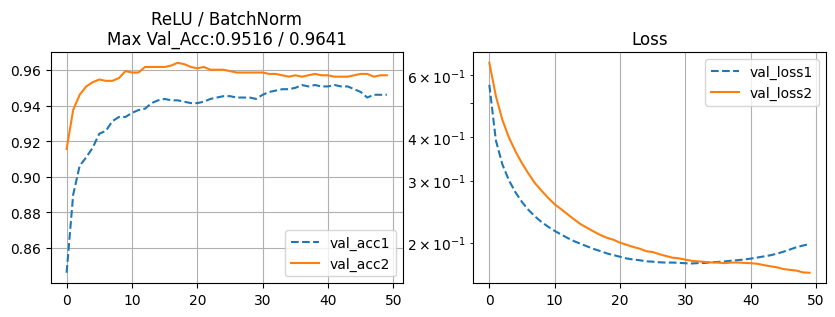

In [28]:
h2 = history.drop('step', axis=1).groupby('epoch').last()
max_1 = h1['val_acc'].max()
max_2 = h2['val_acc'].max()

plt.figure(figsize=(10,3))
title = "ReLU / BatchNorm"
plt.subplot(121)
plt.title(f"{title}\nMax Val_Acc:{max_1:.4f} / {max_2:.4f}")
plt.plot(h1['val_acc'],'--', label='val_acc1')
plt.plot(h2['val_acc'], label='val_acc2')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['val_loss'],'--', label='val_loss1')
plt.plot(h2['val_loss'], label='val_loss2')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

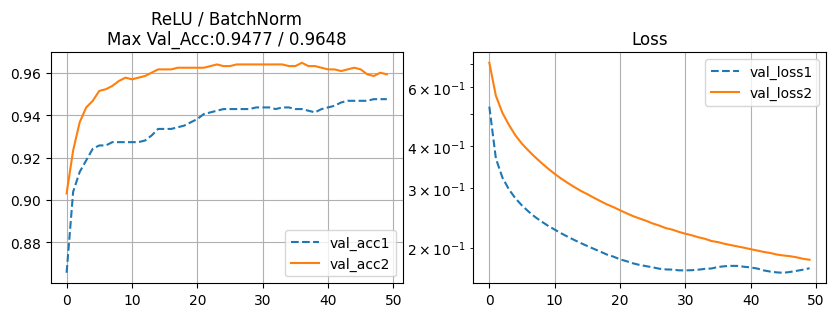

## Weight Decay Regularization

**묵시적인 상속**

In [29]:
l2_regularization = 0.0005
class Model6(Model):
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005,
                                weight_decay=l2_regularization)

model = Model6()
summary(model, input_size=(8, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model6                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 128]                  100,480
│    └─ReLU: 2-3                         [8, 128]                  --
│    └─Linear: 2-4                       [8, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.81
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.41
Estimated Total Size (MB): 0.44

**명시적인 상속 + 확장성**

In [30]:
l2_regularization = 0.005

class Model6(Model):
    def __init__(self, lr=0.001, weight_decay=0.0):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr,
                                weight_decay=self.weight_decay)

model = Model6(weight_decay=l2_regularization)
summary(model, input_size=(8, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model6                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Flatten: 2-1                      [8, 784]                  --
│    └─Linear: 2-2                       [8, 128]                  100,480
│    └─ReLU: 2-3                         [8, 128]                  --
│    └─Linear: 2-4                       [8, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.81
Input size (MB): 0.03
Forward/backward pass size (MB): 0.01
Params size (MB): 0.41
Estimated Total Size (MB): 0.44

In [31]:
%%time
model = Model6()

name = 'WeightDecay'
logger = L.pytorch.loggers.CSVLogger("logs", name=name)
trainer = L.Trainer(max_epochs=epochs, logger=logger, overfit_batches=0.25,enable_model_summary=False)
trainer.fit(model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 23.5 s, sys: 15.7 s, total: 39.2 s
Wall time: 1min 8s


Wall time: 1min 18s

In [32]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')

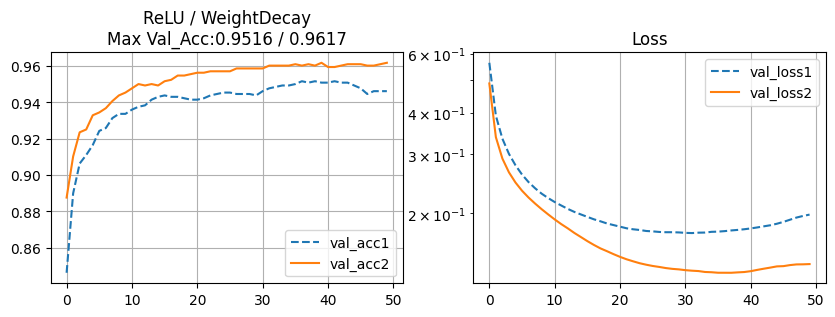

In [33]:
h2 = history.drop('step', axis=1).groupby('epoch').last()
max_1 = h1['val_acc'].max()
max_2 = h2['val_acc'].max()

plt.figure(figsize=(10,3))
title = "ReLU / WeightDecay"
plt.subplot(121)
plt.title(f"{title}\nMax Val_Acc:{max_1:.4f} / {max_2:.4f}")
plt.plot(h1['val_acc'],'--', label='val_acc1')
plt.plot(h2['val_acc'], label='val_acc2')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['val_loss'],'--', label='val_loss1')
plt.plot(h2['val_loss'], label='val_loss2')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

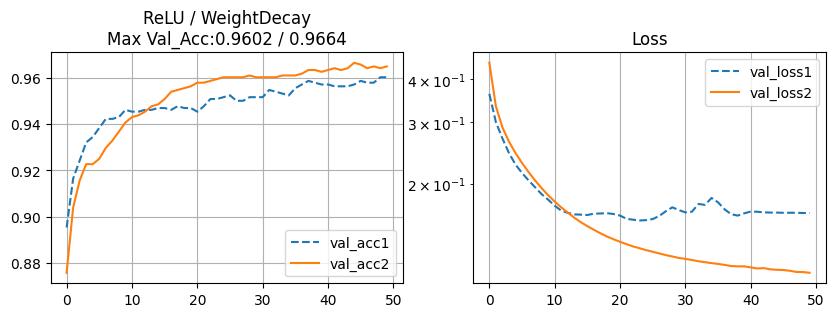

# 실습과제  
## Keras 코드를 PyTorch로 바꾸기  
## 학습결과도 비교해 보자  

## Model 1

In [34]:
import keras

model = keras.models.Sequential()
model.add(keras.Input(shape=(28,28,1)))
model.add(keras.layers.Conv2D(32,(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
#  model.add(keras.layers.MaxPool2D()),
model.add(keras.layers.Conv2D(32,3,strides=2,padding='same',activation='relu'))
model.add(keras.layers.Conv2D(32,3,strides=2,padding='valid',activation='relu'))
model.add(keras.layers.Flatten(name='flatten'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()

# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['acc'])
# history = model.fit(x_train, y_train, epochs=3, batch_size=128, validation_data=(x_test,y_test))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
class Model(Wrap_10):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1,1), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32, 32, 3, stride=2, padding=1), # Adjusted padding for stride=2, matching Keras 'same' approx.
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=2, padding=0), # Adjusted padding to match 'valid' in Keras
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*3*3, 10))

    def forward(self, x):
        x = self.layers(x)
        return x

model = Model()
summary(model, input_size=(8, 1, 28, 28)) # Changed channel dimension (Batch size, Channels, Height, Width)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 32, 28, 28]           320
│    └─ReLU: 2-2                         [8, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [8, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [8, 32, 7, 7]             9,248
│    └─ReLU: 2-5                         [8, 32, 7, 7]             --
│    └─Conv2d: 2-6                       [8, 32, 3, 3]             9,248
│    └─ReLU: 2-7                         [8, 32, 3, 3]             --
│    └─Flatten: 2-8                      [8, 288]                  --
│    └─Linear: 2-9                       [8, 10]                   2,890
Total params: 21,706
Trainable params: 21,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 6.32
Input size (MB): 0.03
Forward/backw

## Model 2

In [36]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(keras.layers.Flatten(name='flatten'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,962 (1.14 MB)

 Trainable params: 297,962 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
class Model2(Wrap_10):
    def __init__(self):
        super(Model2, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1,1), padding="same"),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3,3), stride=(1,1), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(32, 64, 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64, 128, 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Flatten(),
            nn.Linear(128*3*3, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

model = Model2()
summary(model, input_size=(8, 1, 28, 28)) # Changed channel dimension (Batch size, Channels, Height, Width)

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 32, 28, 28]           320
│    └─ReLU: 2-2                         [8, 32, 28, 28]           --
│    └─Conv2d: 2-3                       [8, 32, 28, 28]           9,248
│    └─ReLU: 2-4                         [8, 32, 28, 28]           --
│    └─MaxPool2d: 2-5                    [8, 32, 14, 14]           --
│    └─Conv2d: 2-6                       [8, 64, 14, 14]           18,496
│    └─ReLU: 2-7                         [8, 64, 14, 14]           --
│    └─Conv2d: 2-8                       [8, 64, 14, 14]           36,928
│    └─ReLU: 2-9                         [8, 64, 14, 14]           --
│    └─MaxPool2d: 2-10                   [8, 64, 7, 7]             --
│    └─Conv2d: 2-11                      [8, 128, 7, 7]            73,856